# **Importing Libraries**

In [ ]:
#Importing Libraries
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import numpy as np
import tensorflow as tf
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

# **Reading our dataset**

This dataset is about Johnson and Johnson Stock prices which is from 2000 to 2023. Data is taken from online site *Yahoo Finance*

In [ ]:
#Reading our Dataset
df = pd.read_csv('JNJ.csv')

# **Exploring Dataset**

In [ ]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-06-01,44.62500,44.75000,43.62500,43.84375,24.033800,5231800
1,2000-06-02,43.75000,43.75000,41.25000,42.00000,23.023109,9351400
2,2000-06-05,41.75000,42.62500,41.28125,42.00000,23.023109,5316600
3,2000-06-06,41.75000,42.37500,41.50000,42.06250,23.057371,3196600
4,2000-06-07,42.53125,42.71875,41.84375,41.84375,22.937466,4098200


In [ ]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,5786.000000,5786.000000,5786.000000,5786.000000,5786.000000,5.786000e+03
mean,91.310193,91.966178,90.638329,91.323091,71.963535,8.991212e+06
std,39.754831,40.017084,39.468595,39.749596,44.276197,4.674632e+06
min,41.500000,41.650002,40.250000,41.625000,22.937466,1.279600e+06
25%,60.252499,60.732501,59.872500,60.250000,37.270074,6.094525e+06
50%,67.449997,67.890000,67.099998,67.540001,46.506420,7.885700e+06
75%,127.285002,128.132496,126.110001,127.095001,109.446104,1.053230e+07
max,185.100006,186.690002,184.179993,186.009995,178.456909,9.844020e+07


In [ ]:
df.describe

<bound method NDFrame.describe of             Date        Open        High         Low       Close   Adj Close  \
0     2000-06-01   44.625000   44.750000   43.625000   43.843750   24.033800   
1     2000-06-02   43.750000   43.750000   41.250000   42.000000   23.023109   
2     2000-06-05   41.750000   42.625000   41.281250   42.000000   23.023109   
3     2000-06-06   41.750000   42.375000   41.500000   42.062500   23.057371   
4     2000-06-07   42.531250   42.718750   41.843750   41.843750   22.937466   
...          ...         ...         ...         ...         ...         ...   
5781  2023-05-24  157.080002  157.139999  155.919998  156.660004  155.530777   
5782  2023-05-25  156.050003  156.289993  153.720001  154.410004  153.296997   
5783  2023-05-26  154.690002  155.279999  154.199997  154.350006  153.237427   
5784  2023-05-30  153.970001  155.380005  153.320007  154.369995  153.257263   
5785  2023-05-31  154.699997  155.690002  153.850006  155.059998  153.942307   

     

# **Processing Our Dataset**

In [ ]:
# Extract "Date" and "Close" feature colums from the dataframe.
df = df[['Date', 'Close']]

In [ ]:
# Concise summary of a DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5786 entries, 0 to 5785
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    5786 non-null   object 
 1   Close   5786 non-null   float64
dtypes: float64(1), object(1)
memory usage: 90.5+ KB


In [ ]:
df['Date'].min(), df['Date'].max()

('2000-06-01', '2023-05-31')

Visualizing our processed dataset

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['Date'], y=df['Close'], name='Close price'))
fig.update_layout(showlegend=True, title='Johnson and Johnson Stock Price 2000-2023')
fig.show()

# **Data Training and Model Evaluation**

In [ ]:
# Create the train and test sets
train = df.loc[df['Date'] <= '2020-01-01']
test = df.loc[df['Date'] > '2020-01-01']

# Print the shapes of the train and test sets
train.shape, test.shape

((4927, 2), (859, 2))

In [ ]:
# Creating the scaler and fitting it in traing data
scaler = StandardScaler()
scaler = scaler.fit(np.array(train['Close']).reshape(-1,1))

# Transform the train and test sets
train['Close'] = scaler.transform(np.array(train['Close']).reshape(-1,1))
test['Close'] = scaler.transform(np.array(test['Close']).reshape(-1,1))

<ipython-input-11-79633fc56aae>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-11-79633fc56aae>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



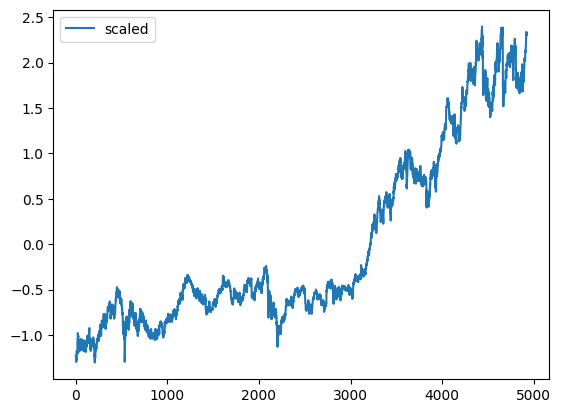

In [ ]:
# Visualize scaled data
plt.plot(train['Close'], label = 'scaled')
plt.legend()
plt.show()

In [ ]:
# Define a constant TIME_STEPS with a value of 30, representing the number of time steps in your sequences.
TIME_STEPS = 30

# Define a function create_sequences that takes input features X and target variable y, along with a time_steps parameter.
def create_sequences(X, y, time_steps=TIME_STEPS):
    X_out, y_out = [], []  # Initialize empty lists to store input sequences (X_out) and corresponding target values (y_out).
    for i in range(len(X) - time_steps):
        # Iterate through the data from the beginning to (length of X - time_steps).

        # Append a sequence of time_steps values from X to X_out. These sequences slide one step at a time.
        X_out.append(X.iloc[i:(i+time_steps)].values)

        # Append the corresponding target value (y) that occurs immediately after the sequence in y_out.
        y_out.append(y.iloc[i + time_steps])

    # Convert the lists into NumPy arrays and return them.
    return np.array(X_out), np.array(y_out)

# Create training sequences for the 'Close' feature using the create_sequences function.
X_train, y_train = create_sequences(train[['Close']], train['Close'])

# Create testing sequences for the 'Close' feature using the create_sequences function.
X_test, y_test = create_sequences(test[['Close']], test['Close'])

# Print the shapes (dimensions) of the training and testing input sequences.
print("Training input shape: ", X_train.shape)
print("Testing input shape: ", X_test.shape)


Training input shape:  (4897, 30, 1)
Testing input shape:  (829, 30, 1)


In [ ]:
# set seed to regenerate same sequence of random numbers.
np.random.seed(21)
tf.random.set_seed(21)

In [ ]:
# Create a Sequential model, which is a linear stack of layers.
model = Sequential()

# Add an LSTM layer with 128 units, using 'tanh' as the activation function.
# The 'input_shape' parameter specifies the shape of the input data, which matches the shape of the training sequences.
model.add(LSTM(128, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])))

# Add a Dropout layer with a dropout rate of 20%.
model.add(Dropout(rate=0.2))

# Add a RepeatVector layer that repeats the input 'X_train.shape[1]' times.
# This layer is often used to bridge between encoder and decoder parts in sequence-to-sequence models.
model.add(RepeatVector(X_train.shape[1]))

# Add another LSTM layer with 128 units, using 'tanh' as the activation function.
# The 'return_sequences=True' parameter indicates that this LSTM layer will return sequences.
model.add(LSTM(128, activation='tanh', return_sequences=True))

# Add another Dropout layer with a dropout rate of 20%.
model.add(Dropout(rate=0.2))

# Add a TimeDistributed layer with a Dense layer.
# This layer applies a Dense operation to each time step in the sequence independently.
model.add(TimeDistributed(Dense(X_train.shape[2])))

# Compile the model with the Adam optimizer and a learning rate of 0.001.
# The loss function is mean squared error (MSE), which is commonly used for regression problems.
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")

# Display a summary of the model architecture, including the number of parameters in each layer.
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 repeat_vector (RepeatVector  (None, 30, 128)          0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 30, 128)           131584    
                                                                 
 dropout_1 (Dropout)         (None, 30, 128)           0         
                                                                 
 time_distributed (TimeDistr  (None, 30, 1)            129       
 ibuted)                                                

In [ ]:
# Train the model using the fit method.

# Provide the training data X_train and target data y_train.
# 'epochs' specifies the number of training iterations.
# 'batch_size' determines how many samples are used in each training update.
# 'validation_split' allocates a portion of the training data (10% in this case) as a validation set.
# 'callbacks' is a list of callback functions to be applied during training.
# In this case, you're using EarlyStopping to stop training if the validation loss doesn't improve for 5 consecutive epochs.
# 'shuffle' is set to False to maintain the order of training data (important for time series data).

history = model.fit(X_train,
                    y_train,
                    epochs=100,  # Number of training iterations.
                    batch_size=30,  # Number of samples in each batch.
                    validation_split=0.1,  # 10% of data is used for validation.
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')],
                    shuffle=False)  # Data order is not shuffled.

Epoch 1/100
147/147 [==============================] - 27s 110ms/step - loss: 0.0510 - val_loss: 0.1907
Epoch 2/100
147/147 [==============================] - 15s 104ms/step - loss: 0.0252 - val_loss: 0.0417
Epoch 3/100
147/147 [==============================] - 14s 96ms/step - loss: 0.0167 - val_loss: 0.0363
Epoch 4/100
147/147 [==============================] - 14s 96ms/step - loss: 0.0172 - val_loss: 0.0401
Epoch 5/100
147/147 [==============================] - 14s 96ms/step - loss: 0.0149 - val_loss: 0.0331
Epoch 6/100
147/147 [==============================] - 16s 107ms/step - loss: 0.0159 - val_loss: 0.0575
Epoch 7/100
147/147 [==============================] - 14s 97ms/step - loss: 0.0159 - val_loss: 0.0400
Epoch 8/100
147/147 [==============================] - 14s 97ms/step - loss: 0.0158 - val_loss: 0.0638
Epoch 9/100
147/147 [==============================] - 15s 104ms/step - loss: 0.0165 - val_loss: 0.0536
Epoch 10/100
147/147 [==============================] - 14s 98ms/step

**Result Visuals**

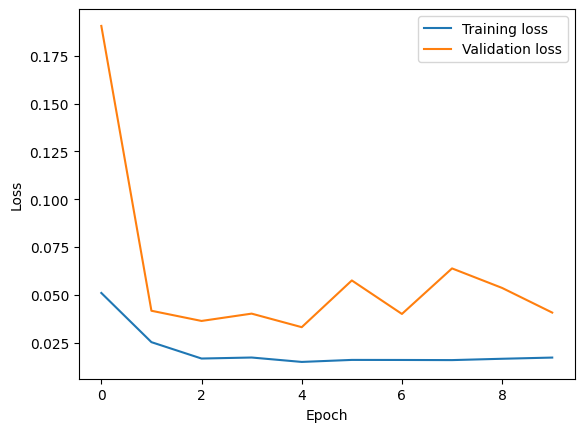

In [ ]:
# Plot the training and validation loss over epochs.

# 'history.history['loss']' contains the training loss values for each epoch.
plt.plot(history.history['loss'], label='Training loss')

# 'history.history['val_loss']' contains the validation loss values for each epoch.
plt.plot(history.history['val_loss'], label='Validation loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend();

154/154 [==============================] - 7s 38ms/step
Reconstruction error threshold: 0.5429275232621703


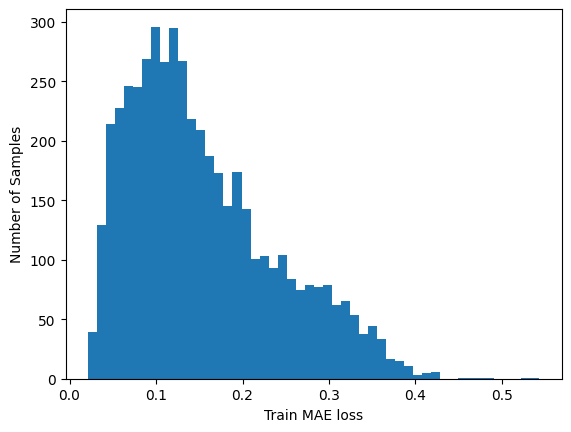

In [ ]:
# Calculate Mean Absolute Error (MAE) loss for training data.
X_train_pred = model.predict(X_train)

# Calculate the mean absolute error (MAE) loss by taking the absolute difference
# between the predicted sequences (X_train_pred) and the original training sequences (X_train).
# 'axis=1' computes the mean MAE loss along the sequence dimension.
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples');

# Set reconstruction error threshold
threshold = np.max(train_mae_loss)

print('Reconstruction error threshold:',threshold)

26/26 [==============================] - 1s 28ms/step


Text(0, 0.5, 'Number of samples')

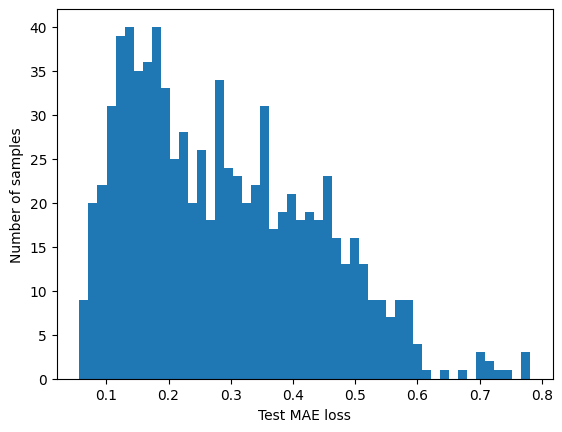

In [ ]:
# Use the trained model to predict the reconstructed sequences for the testing data.
X_test_pred = model.predict(X_test, verbose=1)

# Calculate the mean absolute error (MAE) loss for each testing sample by taking the absolute difference
# between the predicted sequences (X_test_pred) and the original testing sequences (X_test).
# 'axis=1' computes the mean MAE loss along the sequence dimension.
test_mae_loss = np.mean(np.abs(X_test_pred-X_test), axis=1)

plt.hist(test_mae_loss, bins=50)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of samples')

In [ ]:
# Create a DataFrame 'anomaly_df' to store information about anomalies in the testing data.

# Create 'anomaly_df' by selecting rows in the 'test' DataFrame starting from the TIME_STEPS index.
anomaly_df = pd.DataFrame(test[TIME_STEPS:])

# Add a new column 'loss' to 'anomaly_df' containing the Mean Absolute Error (MAE) loss values calculated for the testing data.
anomaly_df['loss'] = test_mae_loss

# Add a new column 'threshold' to 'anomaly_df' and set it to the previously computed 'threshold' value.
anomaly_df['threshold'] = threshold

# Add a new column 'anomaly' to 'anomaly_df' that indicates whether a data point is considered an anomaly.
# If 'loss' is greater than 'threshold', it is marked as 'True' (anomaly), otherwise 'False' (not an anomaly).
anomaly_df['anomaly'] = anomaly_df['loss'] > anomaly_df['threshold']


In [ ]:
anomaly_df.head()

,Date,Close,loss,threshold,anomaly
4957,2020-02-14,2.467320,0.247646,0.542928,False
4958,2020-02-18,2.432915,0.223401,0.542928,False
4959,2020-02-19,2.425965,0.190570,0.542928,False
4960,2020-02-20,2.406157,0.163635,0.542928,False
4961,2020-02-21,2.460369,0.139741,0.542928,False


In [ ]:
# Create a line plot using Plotly (go.Figure) to visualize the test loss and threshold values over time.

fig = go.Figure()

# Add a line plot for the test loss values.
fig.add_trace(go.Scatter(x=anomaly_df['Date'], y=anomaly_df['loss'], name='Test loss'))

# Add a line plot for the threshold values.
fig.add_trace(go.Scatter(x=anomaly_df['Date'], y=anomaly_df['threshold'], name='Threshold'))
fig.update_layout(showlegend=True, title='Test loss vs. Threshold')
fig.show()


In [ ]:
# Filter the 'anomaly_df' DataFrame to select rows where the 'anomaly' column is 'True',
# indicating that the data point is considered an anomaly.
anomalies = anomaly_df.loc[anomaly_df['anomaly'] == True]

anomalies.head()

,Date,Close,loss,threshold,anomaly
4983,2020-03-24,1.391755,0.718242,0.542928,True
4984,2020-03-25,1.399401,0.724841,0.542928,True
4985,2020-03-26,1.648570,0.700007,0.542928,True
4986,2020-03-27,1.530067,0.583809,0.542928,True
5000,2020-04-17,2.533000,0.595869,0.542928,True


In [ ]:
anomalies.shape

(46, 5)

# **Final Output**

In [ ]:
# Create a Plotly line plot to visualize the detected anomalies in the 'Close' price.
fig = go.Figure()
fig.add_trace(go.Scatter(x=anomaly_df['Date'], y=scaler.inverse_transform(anomaly_df['Close'].values.reshape(-1, 1)).flatten(), name='Close price'))
fig.add_trace(go.Scatter(x=anomalies['Date'], y=scaler.inverse_transform(anomalies['Close'].values.reshape(-1, 1)).flatten(), mode='markers', name='Anomaly'))
fig.update_layout(showlegend=True, title='Detected anomalies')
fig.show()
